# Agent Supervisor

In this example, we define a supervisor agent that acts as an orchestrator (or router) to different, more specific agents.

---

In [1]:
from dotenv import load_dotenv
import pandas as pd
from pathlib import Path
import json
from dotenv import load_dotenv
import os 
import pprint
from IPython.display import Image, display, Markdown
from pydantic import BaseModel
from typing import TypedDict, Annotated, Literal, Dict, Any, List
from typing import Callable, Optional, Sequence, Type, TypeVar, Union, cast
import re
from operator import itemgetter
from typing_extensions import TypedDict



In [2]:
# %pip install -U langgraph langchain_community langchain_openai langchain_experimental langchain-chroma pypdf sentence-transformers

Import the necessary classes from **Langchain** and **Langgraph**

In [2]:
from langchain.chat_models import init_chat_model
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import PyPDFLoader, Docx2txtLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import OpenAIEmbeddings 
from langchain.tools import tool
from langchain_community.utilities import SQLDatabase
from langchain.chains import create_sql_query_chain
# from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
from langchain_community.tools import QuerySQLDatabaseTool
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langgraph.graph import MessagesState, START, END, StateGraph
from langgraph.types import Command
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.prebuilt import create_react_agent

In [3]:
from langchain_core.language_models import BaseChatModel, LanguageModelLike
from langchain_core.messages import AIMessage, BaseMessage, SystemMessage, ToolMessage
from langchain_core.runnables import Runnable, RunnableBinding, RunnableConfig
from langchain_core.tools import BaseTool
from typing_extensions import Annotated, TypedDict
from langgraph.errors import ErrorCode, create_error_message
from langgraph.graph.message import add_messages
from langgraph.managed import IsLastStep, RemainingSteps
from langgraph.prebuilt.tool_node import ToolNode, tools_condition
from langgraph.store.base import BaseStore
from langgraph.types import Checkpointer
from langgraph.utils.runnable import RunnableCallable
from langgraph.checkpoint.memory import InMemorySaver

In [4]:
# Load environment variables from .env file
load_dotenv()

True

## Web Search

In [5]:
web_search_tool = TavilySearchResults(max_results=2)

query = "What is the Chinook SQL database?"
results = web_search_tool.invoke({'query': query})
results

/var/folders/tx/dmzj44qn2s92dyzxj_nrc82c0000gn/T/ipykernel_76831/4268758883.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  web_search_tool = TavilySearchResults(max_results=2)


[{'title': 'Data Dictionary - Chinook | PDF | Relational Model - Scribd',
  'url': 'https://www.scribd.com/document/870659367/Data-Dictionary-Chinook',
  'content': 'The Chinook database is a sample relational database designed for teaching database management and SQL queries, modeling a digital media store with tables for albums, artists, customers, invoices, and more. Each table includes primary keys for unique identification and foreign keys to establish relationships between tables. The document details the structure and constraints of various tables, including Albums, Artists, Customers, Invoices, and others.\n\n# Data Dictionary - Chinook',
  'score': 0.9305657},
 {'title': 'lerocha/chinook-database: Sample database for SQL Server, Oracle ...',
  'url': 'https://github.com/lerocha/chinook-database',
  'content': '## Repository files navigation\n\n## Chinook Database\n\nChinook is a sample database available for SQL Server, Oracle, MySQL, etc. It can be created by running a single

## Ingestion of Documents (for RAG)

In [6]:
def load_documents(folder_path: str) -> List[Document]:
    documents = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.endswith('.pdf'):
            print(f"Loading {filename} OK")
            loader = PyPDFLoader(file_path)
        elif filename.endswith('.docx'):
            print(f"Loading {filename} OK")
            loader = Docx2txtLoader(file_path)
        else:
            print(f"Unsupported file type: {filename}")
            continue
        documents.extend(loader.load())
    return documents

folder_path = "./data"
documents = load_documents(folder_path)
print(f"Loaded {len(documents)} documents from the folder.")

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len
)

splits = text_splitter.split_documents(documents)
print(f"Split the documents into {len(splits)} chunks.")

Unsupported file type: .DS_Store
Loading Mastering SQL with the Chinook Database: A Journey Through Music Data Analytics | by Chiamaka Okakpu | Medium.pdf OK


Ignoring wrong pointing object 19 0 (offset 0)
Ignoring wrong pointing object 33 0 (offset 0)
Ignoring wrong pointing object 14 0 (offset 0)


Unsupported file type: chinookdb.sqlite
Loading SQLite Sample Database And Its Diagram (in PDF format).pdf OK
Loaded 16 documents from the folder.
Split the documents into 25 chunks.


In [7]:
vectorstore = InMemoryVectorStore(OpenAIEmbeddings())
_ = vectorstore.add_documents(documents=splits)

retriever = vectorstore.as_retriever(search_kwargs={"k": 2})
retriever_results = retriever.invoke(query)
print(retriever_results)

[Document(id='35144f74-a24c-4d1c-a69f-5998ec0baeec', metadata={'producer': 'macOS Version 14.7.2 (Build 23H311) Quartz PDFContext', 'creator': 'Safari', 'creationdate': "D:20250826024702Z00'00'", 'title': 'Mastering SQL with the Chinook Database: A Journey Through Music Data Analytics | by Chiamaka Okakpu | Medium', 'moddate': "D:20250826024702Z00'00'", 'source': './data/Mastering SQL with the Chinook Database: A Journey Through Music Data Analytics | by Chiamaka Okakpu | Medium.pdf', 'total_pages': 12, 'page': 1, 'page_label': '2'}, page_content='25/08/2025, 11:47\u202fPMMastering SQL with the Chinook Database: A Journey Through Music Data Analytics | by Chiamaka Okakpu | Medium\nPage 2 of 12https://medium.com/@chizobaokakpu65/mastering-sql-with-the-chinook-database-a-journey-through-music-data-analytics-f1d01cd4455a\nPhoto by Sincerely Media on Unsplash\nIntroduction\nData analysis is like solving a puzzle, and SQL is one of the most powerful\ntools in a data analyst’s toolkit. Recen

In [8]:
class RagToolSchema(BaseModel):
    question: str

@tool(args_schema=RagToolSchema)
def retriever_tool(question):
  """Tool to Retrieve Semantically Similar documents to answer User Questions related to example SQL databases"""
  print("INSIDE RETRIEVER NODE")
  retriever = vectorstore.as_retriever(search_kwargs={"k": 2})
  retriever_results = retriever.invoke(question)
  return "\n\n".join(doc.page_content for doc in retriever_results)

## Text 2 SQL 

In [9]:
db = SQLDatabase.from_uri("sqlite:///data//chinookdb.sqlite")

In [10]:
def clean_sql_query(text: str) -> str:
    """
    Clean SQL query by removing code block syntax, various SQL tags, backticks,
    prefixes, and unnecessary whitespace while preserving the core SQL query.

    Args:
        text (str): Raw SQL query text that may contain code blocks, tags, and backticks

    Returns:
        str: Cleaned SQL query
    """
    # Step 1: Remove code block syntax and any SQL-related tags
    # This handles variations like ```sql, ```SQL, ```SQLQuery, etc.
    block_pattern = r"```(?:sql|SQL|SQLQuery|mysql|postgresql)?\s*(.*?)\s*```"
    text = re.sub(block_pattern, r"\1", text, flags=re.DOTALL)

    # Step 2: Handle "SQLQuery:" prefix and similar variations
    # This will match patterns like "SQLQuery:", "SQL Query:", "MySQL:", etc.
    prefix_pattern = r"^(?:SQL\s*Query|SQLQuery|MySQL|PostgreSQL|SQL)\s*:\s*"
    text = re.sub(prefix_pattern, "", text, flags=re.IGNORECASE)

    # Step 3: Extract the first SQL statement if there's random text after it
    # Look for a complete SQL statement ending with semicolon
    sql_statement_pattern = r"(SELECT.*?;)"
    sql_match = re.search(sql_statement_pattern, text, flags=re.IGNORECASE | re.DOTALL)
    if sql_match:
        text = sql_match.group(1)

    # Step 4: Remove backticks around identifiers
    text = re.sub(r'`([^`]*)`', r'\1', text)

    # Step 5: Normalize whitespace
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)

    # Step 6: Preserve newlines for main SQL keywords to maintain readability
    keywords = ['SELECT', 'FROM', 'WHERE', 'GROUP BY', 'HAVING', 'ORDER BY',
               'LIMIT', 'JOIN', 'LEFT JOIN', 'RIGHT JOIN', 'INNER JOIN',
               'OUTER JOIN', 'UNION', 'VALUES', 'INSERT', 'UPDATE', 'DELETE']

    # Case-insensitive replacement for keywords
    pattern = '|'.join(r'\b{}\b'.format(k) for k in keywords)
    text = re.sub(f'({pattern})', r'\n\1', text, flags=re.IGNORECASE)

    # Step 7: Final cleanup
    # Remove leading/trailing whitespace and extra newlines
    text = text.strip()
    text = re.sub(r'\n\s*\n', '\n', text)

    return text

In [11]:
class SQLToolSchema(BaseModel):
    question: str

@tool(args_schema=SQLToolSchema)
def nl2sql_tool(question):
  """Tool to Generate and Execute SQL Query to answer User Questions related to chinook DB"""
  print("INSIDE NL2SQL TOOL")
  execute_query = QuerySQLDatabaseTool(db=db)
  write_query = create_sql_query_chain(llm, db)

  chain = (
      RunnablePassthrough.assign(query=write_query | RunnableLambda(clean_sql_query)).assign(
          result=itemgetter("query") | execute_query
      )
  )

  response = chain.invoke({"question": question})
  return response['result']


We define an LLM model to use in a zero-shot mode to answer user questions

In [12]:
llm_model = "openai:"+os.getenv("OPENAI_MODEL")
print(llm_model)
llm = init_chat_model(llm_model, temperature=0)

openai:gpt-4o-mini


In [13]:
question = "How many employees are there?"
result = nl2sql_tool.invoke({"question": question})
print(f"Question: {question}")
print(f"Answer: {result}")

INSIDE NL2SQL TOOL
Question: How many employees are there?
Answer: [(8,)]


## Creation of Supervisor Agent (as a graph)

In [14]:
members = ["web_researcher", "rag", "nl2sql"]
# Our supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

SYSTEM_PROMPT = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal["web_researcher", "rag", "nl2sql","FINISH"]


def supervisor_node(state: MessagesState) -> Command[Literal["web_researcher", "rag", "nl2sql", "__end__"]]:
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    print(f"Next Worker: {goto}")
    if goto == "FINISH":
        goto = END

    return Command(goto=goto)

We define a function to create ReAct agents (as graphs)

In [15]:
class AgentState(TypedDict):
    """The state of the agent."""

    messages: Annotated[Sequence[BaseMessage], add_messages]

def create_agent(llm, tools):
    llm_with_tools = llm.bind_tools(tools)
    def chatbot(state: AgentState):
      return {"messages": [llm_with_tools.invoke(state["messages"])]}
    graph_builder = StateGraph(AgentState)
    graph_builder.add_node("agent", chatbot)

    tool_node = ToolNode(tools=tools)
    graph_builder.add_node("tools", tool_node)

    graph_builder.add_conditional_edges(
        "agent",
        tools_condition,
    )
    # Any time a tool is called, we return to the chatbot to decide the next step
    graph_builder.add_edge("tools", "agent")
    graph_builder.set_entry_point("agent")
    graph = graph_builder.compile()
    return graph

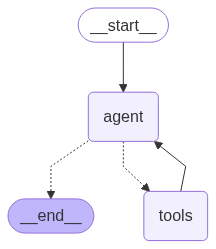

In [16]:
websearch_agent = create_agent(llm, [web_search_tool])

def web_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = websearch_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_researcher")
            ]
        },
        goto="supervisor",
    )
    
display(Image(websearch_agent.get_graph().draw_mermaid_png()))


In [19]:
query = "what is the weather in delhi today?"
result = websearch_agent.invoke({"messages": [("user", query)]})
result['messages'][-1].content

'Today in Delhi, the weather is expected to be partly cloudy with temperatures reaching a high of around 36°C and a low of about 28°C. There may be some patchy rain possible later in the day. \n\nFor more detailed information, you can check the weather forecast on [AccuWeather](https://www.accuweather.com/en/in/delhi/202396/august-weather/202396).'

In [17]:
rag_agent = create_agent(llm, [retriever_tool])

def rag_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = rag_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="rag")
            ]
        },
        goto="supervisor",
    )

# display(Image(rag_agent.get_graph().draw_mermaid_png()))


In [19]:
nl2sql_agent = create_agent(llm, [nl2sql_tool])

def nl2sql_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = nl2sql_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="nl2sql")
            ]
        },
        goto="supervisor",
    )

# display(Image(nl2sql_agent.get_graph().draw_mermaid_png()))


This is the final graph that orchestrates the agents

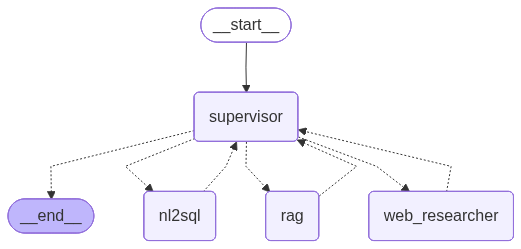

In [20]:
builder = StateGraph(MessagesState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("web_researcher", web_research_node)
builder.add_node("rag", rag_node)
builder.add_node("nl2sql", nl2sql_node)

memory = InMemorySaver()
graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))


Testing the supervisor agent

In [21]:
question = "what is the current weather in Kolkata"
config = {"configurable": {"thread_id": "1"}}

for s in graph.stream(
    {"messages": [("user", question)]}, subgraphs=True, config=config
):
    print(s)
    print("----")

Next Worker: web_researcher
((), {'supervisor': None})
----
(('web_researcher:c62f7a89-7bb1-f4b5-8cd0-c4c68cface06',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tl9tQoKAoPDiAttODRADIsw7', 'function': {'arguments': '{"query":"current weather in Kolkata"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 86, 'total_tokens': 107, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C9K4fZAo6osAFM9YhTI5qYOp4V9td', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--418cb165-4e32-4b0e-911b-f5fb612841b2-0', tool_calls=[{'name': 'tavily_search_results_json', '

In [22]:
state = graph.get_state(config)
ChatPromptTemplate.from_messages(state.values["messages"]).pretty_print()

================================ Human Message =================================

what is the current weather in Kolkata

================================ Human Message =================================
Name: web_researcher

The current weather in Kolkata shows a minimum temperature of around 26°C and a maximum temperature reaching up to 31°C. The temperature is expected to hover around 27°C throughout the day, with a wind speed of approximately 6.16 km/h coming from 160 degrees and gusting up to 8.76 km/h. 

For more detailed information, you can check the full forecast [here](https://www.indiatoday.in/weather/kolkata-weather-forecast-today).


In [23]:
question = "Find the top-5 artists, and then do a web research on them"

for s in graph.stream(
    {"messages": [("user", question)]}, subgraphs=True, config=config
):
    print(s)
    print("----")

Next Worker: rag
((), {'supervisor': None})
----
INSIDE RETRIEVER NODE(('rag:c2cc6c35-cbe5-cd47-d66a-b08c59cd3335',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Z79RcAZh7jWqqO55mqLEZFLc', 'function': {'arguments': '{"question":"top 5 artists"}', 'name': 'retriever_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 190, 'total_tokens': 209, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C9K5RmxkPN3PkYx9H6A7cmWvFrqFT', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--30d246db-da3a-432c-8a4b-6a2a89be6506-0', tool_calls=[{'name': 'retriever_tool', 'args': {'question': 'top 5 artists

In [24]:
state = graph.get_state(config)
ChatPromptTemplate.from_messages(state.values["messages"]).pretty_print()

================================ Human Message =================================

what is the current weather in Kolkata

================================ Human Message =================================
Name: web_researcher

The current weather in Kolkata shows a minimum temperature of around 26°C and a maximum temperature reaching up to 31°C. The temperature is expected to hover around 27°C throughout the day, with a wind speed of approximately 6.16 km/h coming from 160 degrees and gusting up to 8.76 km/h. 

For more detailed information, you can check the full forecast [here](https://www.indiatoday.in/weather/kolkata-weather-forecast-today).

================================ Human Message =================================

Find the top-5 artists, and then do a web research on them

================================ Human Message =================================
Name: rag

The top 5 artists based on the data retrieved are:

1. **Led Zeppelin**
   - Known for dominating the rock scene 

In [25]:
state.values["messages"][-1].content

'Here is a detailed overview of the top 4 artists based on the data retrieved:\n\n### 1. Led Zeppelin\n- **Overview**: Led Zeppelin is a legendary British rock band formed in 1968, known for their heavy guitar-driven sound and innovative blend of rock, blues, and folk music. They are often credited as one of the progenitors of hard rock and heavy metal.\n- **Impact**: The band significantly influenced the music industry, particularly in the development of album-oriented rock and stadium rock. They were inducted into the Rock and Roll Hall of Fame in 1995 and are considered one of the most enduring bands in rock history.\n- **Notable Works**: Albums like "Led Zeppelin IV" and "Physical Graffiti" are among their most acclaimed.\n- **Further Reading**: [Led Zeppelin Merges Hard Rock and Folk Music - EBSCO](https://www.ebsco.com/research-starters/history/led-zeppelin-merges-hard-rock-and-folk-music)\n\n### 2. Iron Maiden\n- **Overview**: Iron Maiden is a British heavy metal band formed in 

In [28]:
# response = graph.invoke({"messages": [("user", question)]})
# display(Markdown(response["messages"][-1].content))
display(Markdown(state.values["messages"][-1].content))

Here is the information I found about the top two artists, Led Zeppelin and Iron Maiden:

### 1. Led Zeppelin
- **Overview**: Led Zeppelin is one of the best-selling music artists of all time, with estimated record sales of between 200 and 300 million units worldwide. They achieved eight consecutive UK number-one albums and six number-one albums on the US Billboard 200, with five of their albums certified Diamond in the US by the Recording Industry Association of America (RIAA).
- **Influence**: They are often described as "the heaviest band of all time" and "the biggest band of the seventies." Their music style drew from various influences, including blues and folk music, and they are credited with significantly impacting the music industry.
- **More Information**: You can read more about them on their [Wikipedia page](https://en.wikipedia.org/wiki/Led_Zeppelin) or watch a [documentary](https://www.youtube.com/watch?v=H6-C4grfWMU) about their history.

### 2. Iron Maiden
- **Overview**: Iron Maiden is an English heavy metal band formed in 1975 by bassist and primary songwriter Steve Harris. The band is known for its pioneering role in the new wave of British heavy metal movement.
- **Line-up**: The most recognized line-up includes Harris, lead vocalist Bruce Dickinson, drummer Nicko McBrain, and guitarists Dave Murray, Adrian Smith, and Janick Gers.
- **Notable Works**: They released their self-titled album in 1980, which debuted at number 4 in the UK Albums Chart and included popular tracks like "Running Free" and "Phantom of the Opera."
- **More Information**: For further details, visit their [Wikipedia page](https://en.wikipedia.org/wiki/Iron_Maiden).

If you would like to find information on the other three artists or need anything else, please let me know!

---

Alternatively, you can try the prebuilt templates provided by Langgraph:
* https://github.com/langchain-ai/react-agent
* https://github.com/langchain-ai/langgraph-supervisor-py